# Custom Time Series Model

## import libraries

In [85]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt


from datetime import datetime, timedelta


import sys
import os


sys.path.append(os.path.abspath('../..'))
from utils.db import get_db
from utils import find_missing_dates
from utils.fill_dates import fill_missing_dates
from utils.holidays import holidays

In [86]:
engine = get_db()

## get data

In [87]:
yesterday = datetime.now() - timedelta(days=1)
print(f"Yesterday: {yesterday.strftime('%m-%d-%Y')}") 
end_date = yesterday

Yesterday: 06-16-2025


In [110]:
query = f"""
select sale_date, sum(total_sales) as sales
    from sales
    where store_number='440'
    and sale_type in ('Sale')
    and item_ring_type in ('ITEM', 'SUBD')
    and sale_date between '1/1/2024' and '{end_date}'
group by sale_date
order by sale_date

"""

In [111]:
ds = pd.read_sql(query, engine)

2025-06-17 16:11:21,491 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-06-17 16:11:21,491 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_catalog.pg_class.oid) AND pg_catalog.pg_namespace.nspname != %(nspname_1)s
2025-06-17 16:11:21,491 INFO sqlalchemy.engine.Engine [cached since 347.7s ago] {'table_name': "\nselect sale_date, sum(total_sales) as sales\n    from sales\n    where store_number='440'\n    and sale_type in ('Sale')\n    and item_ring_type in ('ITEM', 'SUBD')\n    and sale_date between '1/1/2024' and '2025-06-16 16:04:31.718930'\ngroup by sale_date\norder by sale_date\n\n", 'param_1': 'r', 'param_2': 'p', 'param_3': 'f', 'param_4': 'v',

In [112]:
ds.head()

,sale_date,sales
0,2024-02-22,26794.41
1,2024-02-23,32036.08
2,2024-02-24,27247.97
3,2024-02-25,32901.66
4,2024-02-26,24476.21


In [113]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479 entries, 0 to 478
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   sale_date  479 non-null    datetime64[ns]
 1   sales      479 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 7.6 KB


## prep data

In [114]:
ds['sale_date'] = pd.to_datetime(ds['sale_date'])
ds.sort_values('sale_date', inplace=True)
ds.set_index('sale_date', inplace=True)

In [115]:
ds.describe()

,sales
count,479.000000
mean,30948.901521
std,6114.594045
min,352.980000
25%,27168.265000
50%,30074.850000
75%,33929.300000
max,67972.860000


In [116]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 479 entries, 2024-02-22 to 2025-06-16
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   479 non-null    float64
dtypes: float64(1)
memory usage: 7.5 KB


In [117]:
ds.head()

,sales
sale_date,
2024-02-22,26794.41
2024-02-23,32036.08
2024-02-24,27247.97
2024-02-25,32901.66
2024-02-26,24476.21


In [118]:
ds.index

DatetimeIndex(['2024-02-22', '2024-02-23', '2024-02-24', '2024-02-25',
               '2024-02-26', '2024-02-27', '2024-02-28', '2024-02-29',
               '2024-03-01', '2024-03-02',
               ...
               '2025-06-06', '2025-06-07', '2025-06-08', '2025-06-09',
               '2025-06-10', '2025-06-11', '2025-06-12', '2025-06-14',
               '2025-06-15', '2025-06-16'],
              dtype='datetime64[ns]', name='sale_date', length=479, freq=None)

### plot our data

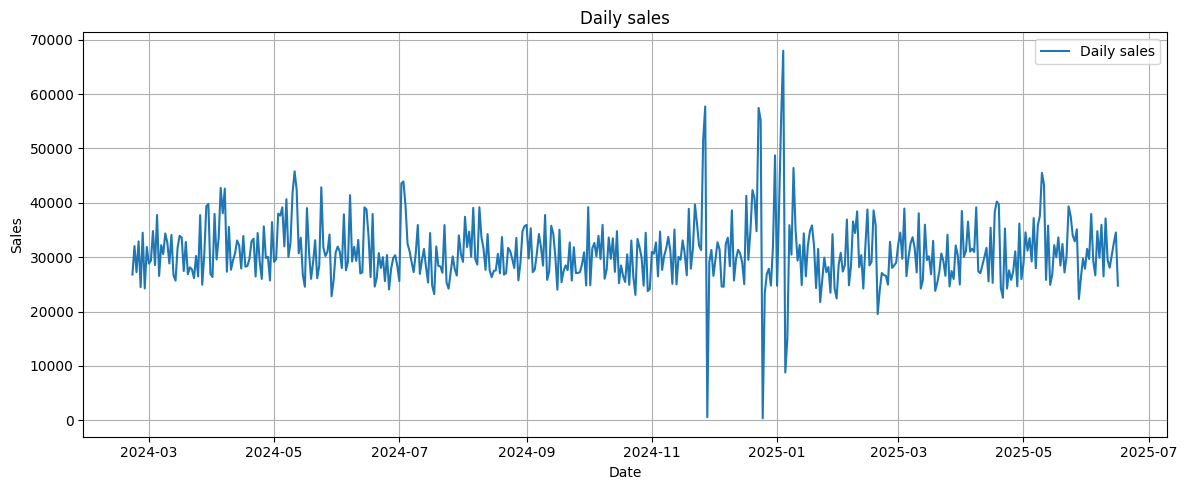

In [119]:
plt.figure(figsize=(12,5))
plt.plot(ds.index, ds['sales'], label='Daily sales')
plt.title('Daily sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

### decomposition

In [120]:
from statsmodels.tsa.seasonal import STL

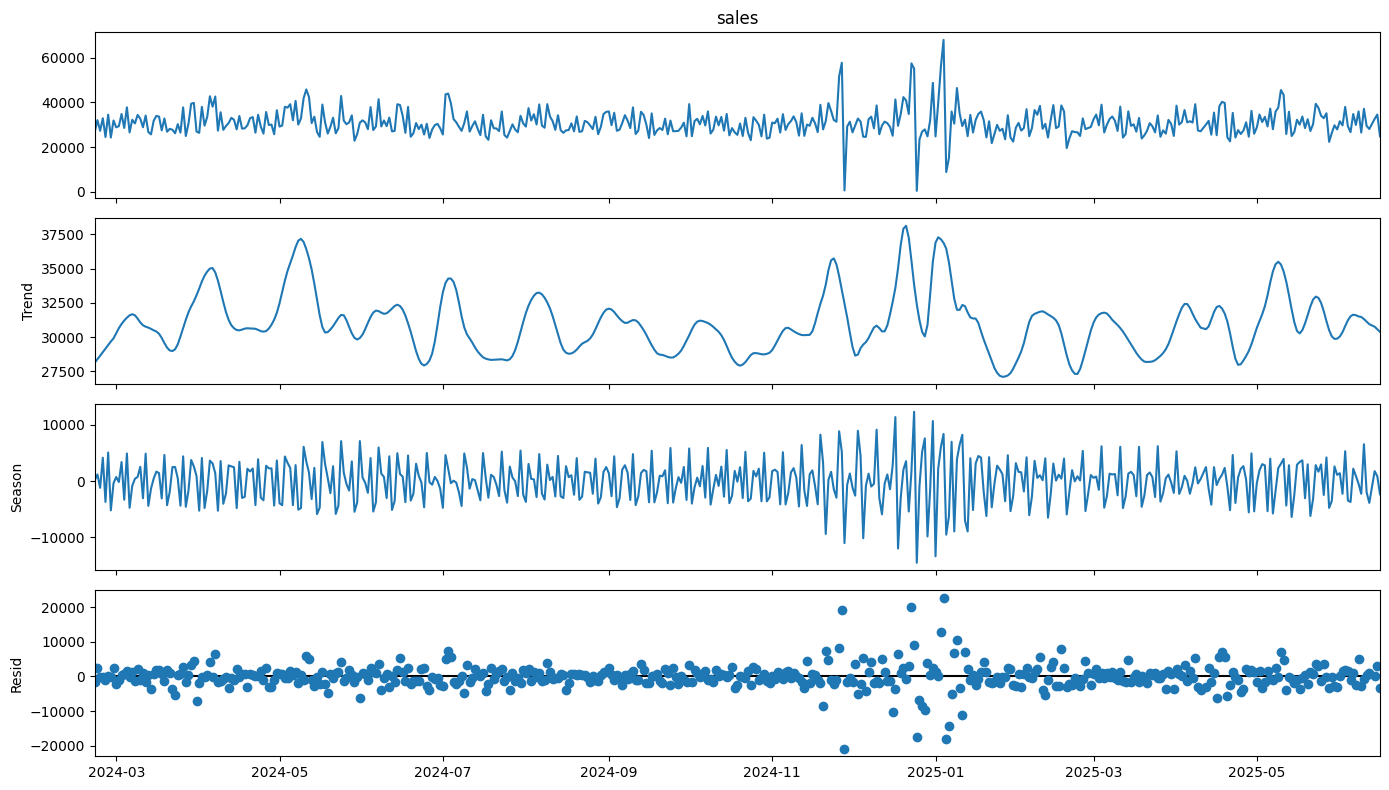

In [121]:
stl = STL(ds['sales'], period=7)
result = stl.fit()

fit = result.plot()
fit.set_size_inches(14,8)
fit.tight_layout()

In [122]:
ds['sales'].max()

np.float64(67972.86000000192)

In [123]:
# get the index of the date with the highest sales
max_sales_date = ds['sales'].idxmax()
max_sales_date


Timestamp('2025-01-04 00:00:00')

### add holidays

In [124]:
holidays.head()

,holiday,ds,lower_window,upper_window
0,christmas,2022-12-25,-2,0
1,christmas,2023-12-25,-2,0
2,christmas,2024-12-25,-2,0
0,new_years,2022-12-31,-2,0
1,new_years,2023-12-31,-2,0


## helpers

In [125]:
def process_holidays(holidays):
    holiday_ranges = []
    for _, row in holidays.iterrows():
        for offset in range(row['lower_window'], row['upper_window'] + 1):
            date = row['ds'] + pd.Timedelta(days=offset)
            holiday_ranges.append({'date': date, 'holiday': row['holiday']})
    holiday_ds = pd.DataFrame(holiday_ranges).drop_duplicates()
    holiday_ds.set_index('date', inplace=True)
    return holiday_ds

In [20]:
def custom_rolling_mean(series, window, min_periods=1):
    """
    Computes a rolling mean after the length of the rolling window is >= min_periods and >= window size.

    Parameters:
    - series: array-like numeric data
    - window: number of trailing points to use
    - min_periods: min required for mean (default = window)

    Returns:
    - Array of rolling mean values
    """
    if min_periods is None:
        min_periods = window

    result = []
    for i in range(len(series)):
        start = max(0, i - window + 1)
        window_vals = series[start:i+1]

        if len(window_vals) >= min_periods and len(window_vals) >= window:
            result.append(np.mean(window_vals))
        else:
            result.append(np.nan)
    return np.array(result)

$
\Large
\text{slope = } m = \frac{\sum{(x_i - \bar{x})(y_i - \bar{y})}}{\sum{(x_i - \bar{x})^2}}
$

$
\Large
\text{intercept = }\bar{y} - m \times \bar{x}
$

In [21]:
def custom_linear_regression(x, y):
    """Computes slope and intercept for a line y = mx + b using least squares.
    
    Paramters:
    - x: array-like numeric data
    - y: array-like numeric data
    
    Returns:
    - slope: float, slope of the line
    - intercept: float, y-intercept of the line
    """
    n = len(x)
    x_mean = np.mean(x)
    y_mean = np.mean(y)

    numerator = np.sum((x - x_mean) * (y - y_mean))
    denominator = np.sum((x - x_mean) ** 2)
    slope = numerator / denominator
    intercept = y_mean - slope * x_mean

    return slope, intercept


## Build the model

### append holidays

In [126]:
holidays_ds = process_holidays(holidays)


In [129]:
holidays_ds.head(5)

,holiday
date,
2022-12-23,christmas
2022-12-24,christmas
2022-12-25,christmas
2023-12-23,christmas
2023-12-24,christmas


In [130]:
ds = ds.merge(holidays_ds,how='left', left_index=True, right_index=True)

In [135]:
ds.head()

,sales,holiday
sale_date,,
2024-02-22,26794.41,NaN
2024-02-23,32036.08,NaN
2024-02-24,27247.97,NaN
2024-02-25,32901.66,NaN
2024-02-26,24476.21,NaN


In [137]:
#ds[ds['holiday'].notna()]

In [27]:
#ds.head(20)

### lags

In [184]:
ds['lag_1'] = ds['sales'].shift(1)
ds['lag_7'] = ds['sales'].shift(7)
ds['lag_mean_1_7'] = ds[['lag_1', 'lag_7']].mean(axis=1)

### trend component

In [138]:
# calculate a rolling average as the trend component
ds['pandas_trend'] = ds['sales'].rolling(window=7).mean()

In [139]:
ds['trend'] = custom_rolling_mean(ds['sales'].values, window=7)


In [523]:
(26794.41 + 32036.08 + 27247.97 + 32901.66 + 24476.21 + 34498.18 + 24238.68) / 7

28884.74142857143

In [140]:
ds.head(20)

,sales,holiday,pandas_trend,trend
sale_date,,,,
2024-02-22,26794.41,NaN,NaN,NaN
2024-02-23,32036.08,NaN,NaN,NaN
2024-02-24,27247.97,NaN,NaN,NaN
2024-02-25,32901.66,NaN,NaN,NaN
2024-02-26,24476.21,NaN,NaN,NaN
2024-02-27,34498.18,NaN,NaN,NaN
2024-02-28,24238.68,NaN,28884.741429,28884.741429
2024-02-29,31872.72,NaN,29610.214286,29610.214286
2024-03-01,28810.18,NaN,29149.371429,29149.371429


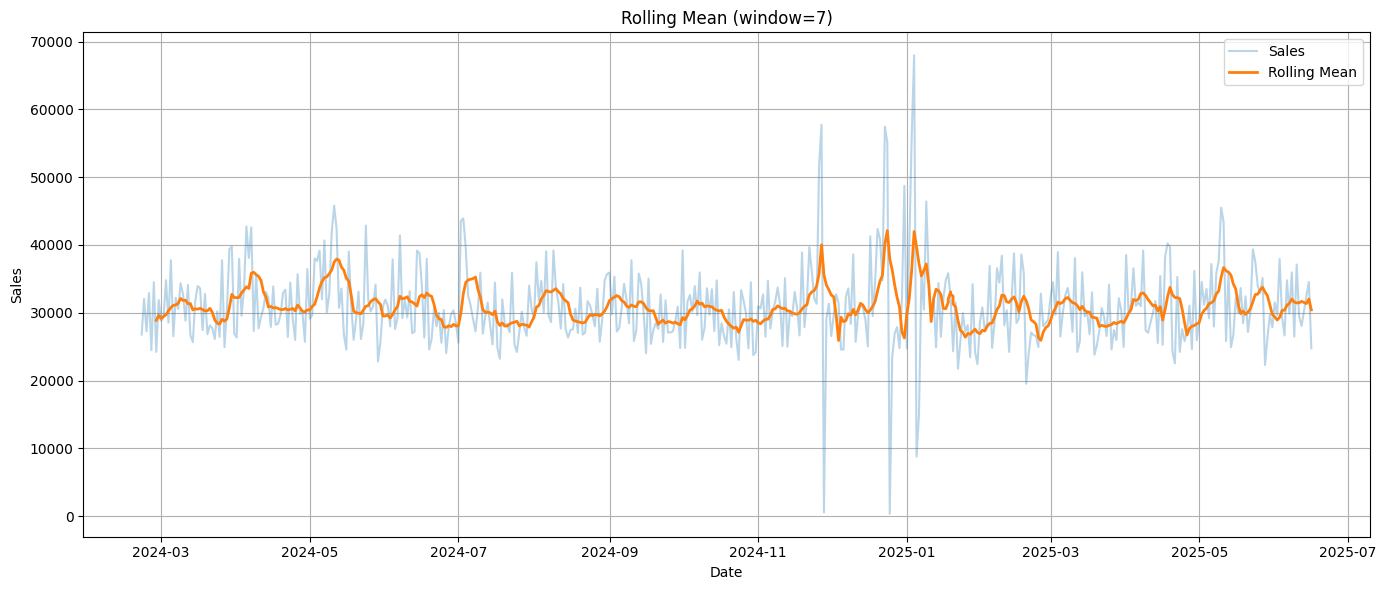

In [141]:
plt.figure(figsize=(14, 6))
plt.plot(ds.index, ds['sales'], label='Sales', alpha=0.3)
plt.plot(ds.index, ds['trend'], label='Rolling Mean', linewidth=2)
#plt.plot(ds.index, ds['custom_trend'], label='Custom Rolling Mean', linestyle='--')
plt.title("Rolling Mean (window=7)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### detrend

💥 why is detrended the sales minus the trend?

we end up with negative numbers

In [142]:
ds['detrended'] = ds['sales'] - ds['trend']

In [143]:
ds

,sales,holiday,pandas_trend,trend,detrended
sale_date,,,,,
2024-02-22,26794.41,NaN,NaN,NaN,NaN
2024-02-23,32036.08,NaN,NaN,NaN,NaN
2024-02-24,27247.97,NaN,NaN,NaN,NaN
2024-02-25,32901.66,NaN,NaN,NaN,NaN
2024-02-26,24476.21,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2025-06-11,29462.71,NaN,31475.394286,31475.394286,-2012.684286
2025-06-12,28056.83,NaN,31674.834286,31674.834286,-3618.004286
2025-06-14,32575.13,NaN,31359.018571,31359.018571,1216.111429


### seasonality

#### Weekdays

lets add a column weekday (0=Monday, 6=Saturday) for every row

In [144]:

ds['weekday'] = ds.index.dayofweek

In [145]:
ds

,sales,holiday,pandas_trend,trend,detrended,weekday
sale_date,,,,,,
2024-02-22,26794.41,NaN,NaN,NaN,NaN,3
2024-02-23,32036.08,NaN,NaN,NaN,NaN,4
2024-02-24,27247.97,NaN,NaN,NaN,NaN,5
2024-02-25,32901.66,NaN,NaN,NaN,NaN,6
2024-02-26,24476.21,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...
2025-06-11,29462.71,NaN,31475.394286,31475.394286,-2012.684286,2
2025-06-12,28056.83,NaN,31674.834286,31674.834286,-3618.004286,3
2025-06-14,32575.13,NaN,31359.018571,31359.018571,1216.111429,5


#### seasonality

group detrended data by weekday and compute the mean deviation for each day

#####   🤔 Why Detrended?

Because we don't want to mix seasonality with trend. We want the relative bump or dip of each weekday, not raw sales

Here we are creating a series that just holds the seasonality factor for each day of the week. Then we will plug that value in for each rows day equivalent

In [146]:
seasonality = ds.groupby('weekday')['detrended'].mean()

In [147]:
seasonality

weekday
0   -3280.894987
1    5294.729043
2   -4068.374472
3   -2466.954493
4    2484.691192
5    1782.938924
6     416.872595
Name: detrended, dtype: float64

now we are going to map the mean weekday seasonal value back into the dataframe

now each row has a seasonal adjustment based on its day

In [156]:
ds[ds['holiday'].notna()]

,sales,holiday,pandas_trend,trend,detrended,weekday,seasonality,residual,holiday_effect
sale_date,,,,,,,,,
2024-03-29,39386.62,easter,30766.390000,30766.390000,8620.230000,4,2484.691192,6135.538808,1077.446239
2024-03-30,39772.98,easter,32713.994286,32713.994286,7058.985714,5,1782.938924,5276.046790,1077.446239
2024-03-31,26929.09,easter,32243.570000,32243.570000,-5314.480000,6,416.872595,-5731.352595,1077.446239
2024-05-25,31784.80,memorial_day,31052.835714,31052.835714,731.964286,5,1782.938924,-1050.974638,1032.749251
2024-05-26,30212.03,memorial_day,31651.955714,31651.955714,-1439.925714,6,416.872595,-1856.798310,1032.749251
2024-05-27,31003.89,memorial_day,31934.490000,31934.490000,-930.600000,0,-3280.894987,2350.294987,1032.749251
2024-07-01,25594.28,forth_of_july,28064.300000,28064.300000,-2470.020000,0,-3280.894987,810.874987,5416.100172
2024-07-02,43560.50,forth_of_july,29945.808571,29945.808571,13614.691429,1,5294.729043,8319.962385,5416.100172
2024-07-03,43917.98,forth_of_july,32782.691429,32782.691429,11135.288571,2,-4068.374472,15203.663043,5416.100172


In [149]:
ds['seasonality'] = ds['weekday'].map(seasonality)

In [151]:
# residual after trend and seasonality
ds['residual'] = ds['detrended'] - ds['seasonality']

In [153]:
#holiday_effect = ds[ds['is_holiday']]['residual'].mean()
per_holiday_effect = ds[ds['holiday'].notna()].groupby('holiday')['residual'].mean()

In [154]:
per_holiday_effect

holiday
christmas          -1727.414147
college_football   -1251.903606
easter              1077.446239
forth_of_july       5416.100172
halloween          -1029.636693
labor_day           2568.939251
memorial_day        1032.749251
new_years           6245.478735
superbowl           2522.313536
thanksgiving        -940.079796
Name: residual, dtype: float64

In [155]:
ds['holiday_effect'] = ds['holiday'].map(per_holiday_effect).fillna(0)

In [ ]:
ds['forecast'] = ds['trend'] + ds['seasonality'] + ds['holiday_effect']
ds['forecast_w_residual'] = ds['forecast'] + ds['residual']
#ds['forecast_lag'] = ds['lag_mean_1_7'] + ds['seasonality'] + ds['holiday_effect']
#ds['forecast_blend'] = (0.6 * ds['trend'] + 0.2 * ds['lag_mean_1_7'] + ds['seasonality'] + ds['holiday_effect'])

In [161]:
ds.head(20)

,sales,holiday,pandas_trend,trend,detrended,weekday,seasonality,residual,holiday_effect,forecast,forecast_w_residual
sale_date,,,,,,,,,,,
2024-02-22,26794.41,NaN,NaN,NaN,NaN,3,-2466.954493,NaN,0.0,NaN,NaN
2024-02-23,32036.08,NaN,NaN,NaN,NaN,4,2484.691192,NaN,0.0,NaN,NaN
2024-02-24,27247.97,NaN,NaN,NaN,NaN,5,1782.938924,NaN,0.0,NaN,NaN
2024-02-25,32901.66,NaN,NaN,NaN,NaN,6,416.872595,NaN,0.0,NaN,NaN
2024-02-26,24476.21,NaN,NaN,NaN,NaN,0,-3280.894987,NaN,0.0,NaN,NaN
2024-02-27,34498.18,NaN,NaN,NaN,NaN,1,5294.729043,NaN,0.0,NaN,NaN
2024-02-28,24238.68,NaN,28884.741429,28884.741429,-4646.061429,2,-4068.374472,-577.686957,0.0,24816.366957,24238.68
2024-02-29,31872.72,NaN,29610.214286,29610.214286,2262.505714,3,-2466.954493,4729.460207,0.0,27143.259793,31872.72
2024-03-01,28810.18,NaN,29149.371429,29149.371429,-339.191429,4,2484.691192,-2823.882621,0.0,31634.062621,28810.18


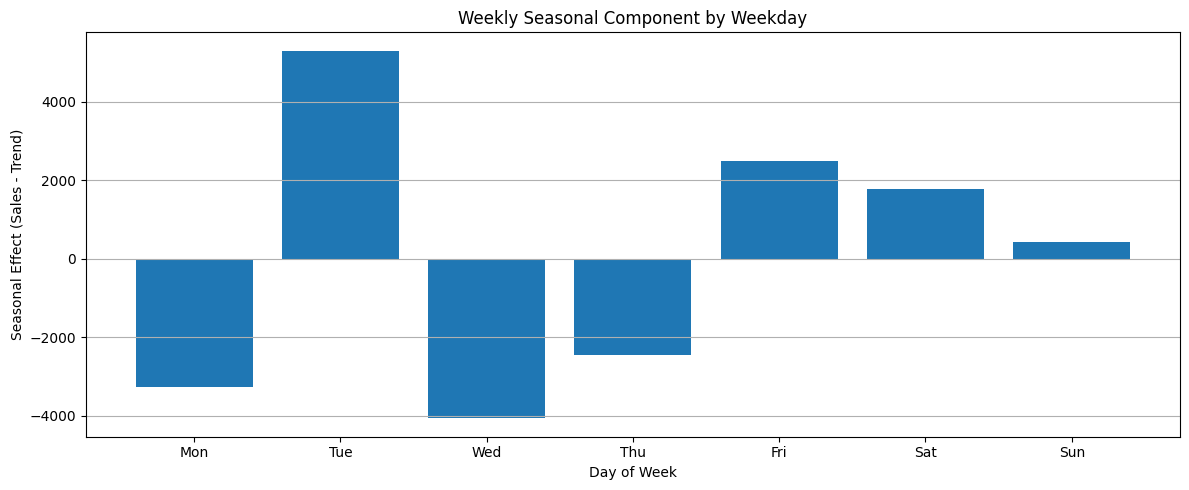

In [162]:
# Plot seasonality
weekday_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

plt.figure(figsize=(12, 5))
plt.bar(weekday_names, seasonality)
plt.title("Weekly Seasonal Component by Weekday")
plt.xlabel("Day of Week")
plt.ylabel("Seasonal Effect (Sales - Trend)")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

In [54]:
ds

,sales,holiday,lag_1,lag_7,lag_mean_1_7,trend,detrended,weekday,seasonality,residual,holiday_effect,forecast
sale_date,,,,,,,,,,,,
2025-02-24,19621.65,NaN,NaN,NaN,NaN,NaN,NaN,0,-1521.184107,NaN,0.0,NaN
2025-02-25,17710.65,NaN,19621.65,NaN,19621.650,NaN,NaN,1,-3319.425524,NaN,0.0,NaN
2025-02-26,24753.21,NaN,17710.65,NaN,17710.650,NaN,NaN,2,-3294.639143,NaN,0.0,NaN
2025-02-27,26925.93,NaN,24753.21,NaN,24753.210,NaN,NaN,3,-2368.981143,NaN,0.0,NaN
2025-02-28,30052.52,NaN,26925.93,NaN,26925.930,NaN,NaN,4,3771.386286,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-12,25967.14,NaN,23748.04,21255.69,22501.865,24871.978571,1095.161429,3,-2368.981143,3464.142571,0.0,22502.997429
2025-06-13,29488.45,NaN,25967.14,26905.01,26436.075,25241.041429,4247.408571,4,3771.386286,476.022286,0.0,29012.427714
2025-06-14,31381.30,NaN,29488.45,29476.29,29482.370,25513.185714,5868.114286,5,5062.107429,806.006857,0.0,30575.293143


## forecasting

In [163]:
forecast_days = 30 # horizon

# generate future dates
last_date = ds.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_days)
future_dates

DatetimeIndex(['2025-06-17', '2025-06-18', '2025-06-19', '2025-06-20',
               '2025-06-21', '2025-06-22', '2025-06-23', '2025-06-24',
               '2025-06-25', '2025-06-26', '2025-06-27', '2025-06-28',
               '2025-06-29', '2025-06-30', '2025-07-01', '2025-07-02',
               '2025-07-03', '2025-07-04', '2025-07-05', '2025-07-06',
               '2025-07-07', '2025-07-08', '2025-07-09', '2025-07-10',
               '2025-07-11', '2025-07-12', '2025-07-13', '2025-07-14',
               '2025-07-15', '2025-07-16'],
              dtype='datetime64[ns]', freq='D')

#### step 1: forecast future trend

do this using the last known trend slope (linear extrapolation)


fit a line to the last 30 trend values

In [164]:
recent_trend = ds['trend'].dropna().tail(30)

In [468]:
#recent_trend

In [165]:
len(recent_trend)

30

In [166]:
x = np.arange(len(recent_trend))

In [553]:
x

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

#### ⚔️ We need a custom version of this

In [167]:
slope, intercept = np.polyfit(x, recent_trend.values, 1)
slope, intercept

(np.float64(5.871138725587819), np.float64(31089.700774194167))

In [168]:
custom_slope, custom_intercept = custom_linear_regression(x, recent_trend.values)
print(f"Custom Slope: {custom_slope}, Custom Intercept: {custom_intercept}")

Custom Slope: 5.871138725588739, Custom Intercept: 31089.700774194152


In [169]:
y = slope * x + intercept # y = mx + b

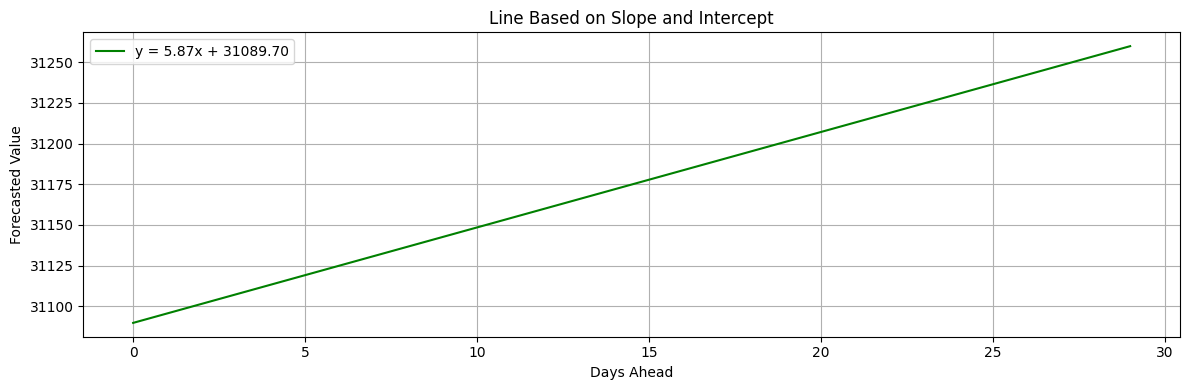

In [170]:
#Plot
plt.figure(figsize=(12, 4))
plt.plot(x, y, label=f'y = {slope:.2f}x + {intercept:.2f}', color='green')
plt.title("Line Based on Slope and Intercept")
plt.xlabel("Days Ahead")
plt.ylabel("Forecasted Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

##### ✅ Starting from today's trend value, move forward one day at a time, adding the slope each day to project future trend values

In [171]:
last_trend = recent_trend.values[-1]

In [172]:
future_ds = pd.DataFrame(index=future_dates)
future_ds['weekday'] = future_ds.index.dayofweek
future_ds['trend'] = slope * np.arange(1, forecast_days + 1) + last_trend
future_ds['seasonality'] = future_ds['weekday'].map(seasonality).fillna(0)


future_ds = future_ds.merge(holidays_ds, how='left', left_index=True, right_index=True)
future_ds['holiday_effect'] = future_ds['holiday'].map(per_holiday_effect).fillna(0)
future_ds['forecast'] = future_ds['trend'] + future_ds['seasonality'] + future_ds['holiday_effect']

In [173]:
future_ds

,weekday,trend,seasonality,holiday,holiday_effect,forecast
2025-06-17,1,30431.616853,5294.729043,NaN,0.0,35726.345897
2025-06-18,2,30437.487992,-4068.374472,NaN,0.0,26369.113520
2025-06-19,3,30443.359130,-2466.954493,NaN,0.0,27976.404638
2025-06-20,4,30449.230269,2484.691192,NaN,0.0,32933.921461
2025-06-21,5,30455.101408,1782.938924,NaN,0.0,32238.040332
2025-06-22,6,30460.972547,416.872595,NaN,0.0,30877.845142
2025-06-23,0,30466.843685,-3280.894987,NaN,0.0,27185.948699
2025-06-24,1,30472.714824,5294.729043,NaN,0.0,35767.443868
2025-06-25,2,30478.585963,-4068.374472,NaN,0.0,26410.211491
2025-06-26,3,30484.457102,-2466.954493,NaN,0.0,28017.502609


#### step 3: Combine to form forecast

In [174]:
# Combine with historical data for plotting
combined = pd.concat([ds[['sales', 'forecast']], future_ds], axis=0)

In [175]:
combined

,sales,forecast,weekday,trend,seasonality,holiday,holiday_effect
2024-02-22,26794.41,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-23,32036.08,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-24,27247.97,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-25,32901.66,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-26,24476.21,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2025-07-12,NaN,32361.334245,5.0,30578.395321,1782.938924,NaN,0.0
2025-07-13,NaN,31001.139055,6.0,30584.266460,416.872595,NaN,0.0
2025-07-14,NaN,27309.242612,0.0,30590.137599,-3280.894987,NaN,0.0
2025-07-15,NaN,35890.737781,1.0,30596.008737,5294.729043,NaN,0.0


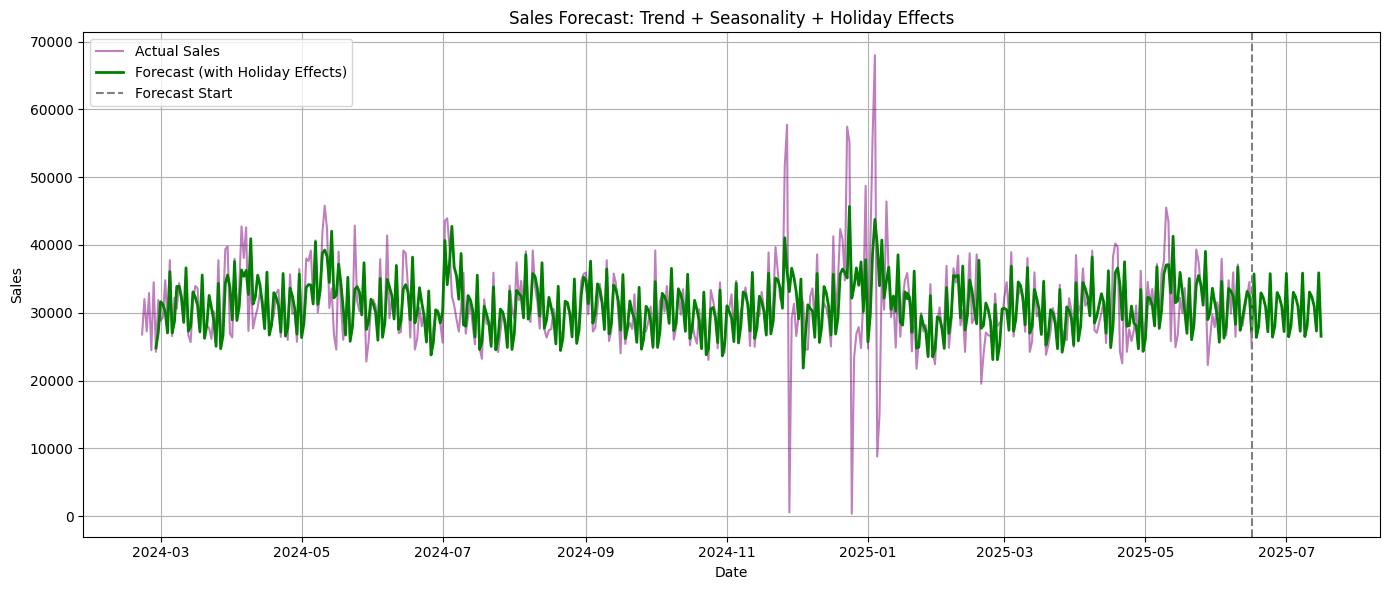

In [176]:
# Plot it
plt.figure(figsize=(14, 6))
plt.plot(combined.index, combined['sales'], label='Actual Sales', alpha=0.5, color='purple')
plt.plot(combined.index, combined['forecast'], label='Forecast (with Holiday Effects)', linewidth=2, color='green')
plt.axvline(x=ds.index[-1], color='gray', linestyle='--', label='Forecast Start')
plt.title("Sales Forecast: Trend + Seasonality + Holiday Effects")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

And there it is — we have our first handcrafted 30-day sales forecast built from the ground up. 🛠️📈

🔮 What This Forecast Includes:
📊 Trend extrapolation using linear slope from the last 30 days

🔁 Weekday-based seasonality applied to each future date

🧠 No machine learning. Just math, intuition, and groceries.

#### 🤔 How bad is it really?

In [177]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [178]:
from utils.metrics import MSE, MAE, RMSE, MAPE, SMAPE

In [179]:
# Drop any rows with NaNs (from early trend calculation)
evaluation_df = ds.dropna(subset=['sales', 'forecast'])

y_true = evaluation_df['sales']
y_pred = evaluation_df['forecast']

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"📊 Model Evaluation Metrics:")
print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²:   {r2:.4f}")

📊 Model Evaluation Metrics:
MAE:  2915.84
MSE:  22459153.61
RMSE: 4739.11
MAPE: 40.66%
R²:   0.4011


In [180]:
# our evaluation metrics internally
custom_mae = MAE(y_true, y_pred)
custom_mse = MSE(y_true, y_pred)
custom_rmse = RMSE(y_true, y_pred)
custom_mape = MAPE(y_true, y_pred)
custom_smape = SMAPE(y_true, y_pred)


print(f"📊 Model Evaluation Metrics:")
print(f"MAE:  {custom_mae:.2f}")
print(f"MSE:  {custom_mse:.2f}")
print(f"RMSE: {custom_rmse:.2f}")
print(f"MAPE: {(custom_mape * 100):.2f}%")
print(f"SMAPE: {(custom_smape * 100):.2f}%")
# print(f"R²:   {r2:.4f}")

📊 Model Evaluation Metrics:
MAE:  2915.84
MSE:  22459153.61
RMSE: 4739.11
MAPE: 40.66%
SMAPE: 9.54%


# ML

In [181]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


In [186]:
ml_ds = ds.copy()
ml_ds['is_holiday'] = ml_ds['holiday'].notna().astype(int)
ml_ds['dayofweek'] = ml_ds.index.dayofweek

In [187]:
ml_ds.head()

,sales,holiday,pandas_trend,trend,detrended,weekday,seasonality,residual,holiday_effect,forecast,forecast_w_residual,lag_1,lag_7,lag_mean_1_7,is_holiday,dayofweek
sale_date,,,,,,,,,,,,,,,,
2024-02-22,26794.41,NaN,NaN,NaN,NaN,3,-2466.954493,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0,3
2024-02-23,32036.08,NaN,NaN,NaN,NaN,4,2484.691192,NaN,0.0,NaN,NaN,26794.41,NaN,26794.41,0,4
2024-02-24,27247.97,NaN,NaN,NaN,NaN,5,1782.938924,NaN,0.0,NaN,NaN,32036.08,NaN,32036.08,0,5
2024-02-25,32901.66,NaN,NaN,NaN,NaN,6,416.872595,NaN,0.0,NaN,NaN,27247.97,NaN,27247.97,0,6
2024-02-26,24476.21,NaN,NaN,NaN,NaN,0,-3280.894987,NaN,0.0,NaN,NaN,32901.66,NaN,32901.66,0,0


In [188]:
features = ['trend', 'lag_1', 'lag_7', 'lag_mean_1_7', 'seasonality', 'is_holiday', 'dayofweek']
ml_ds = ml_ds.dropna(subset=features + ['sales'])

In [189]:
X = ml_ds[features]
y = ml_ds['sales']

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

In [191]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [192]:
X_test.index

DatetimeIndex(['2025-03-12', '2025-03-13', '2025-03-14', '2025-03-15',
               '2025-03-16', '2025-03-17', '2025-03-18', '2025-03-19',
               '2025-03-20', '2025-03-21', '2025-03-22', '2025-03-23',
               '2025-03-24', '2025-03-25', '2025-03-26', '2025-03-27',
               '2025-03-28', '2025-03-29', '2025-03-30', '2025-03-31',
               '2025-04-01', '2025-04-02', '2025-04-03', '2025-04-04',
               '2025-04-05', '2025-04-06', '2025-04-07', '2025-04-08',
               '2025-04-09', '2025-04-10', '2025-04-12', '2025-04-13',
               '2025-04-14', '2025-04-15', '2025-04-16', '2025-04-17',
               '2025-04-18', '2025-04-19', '2025-04-20', '2025-04-21',
               '2025-04-22', '2025-04-23', '2025-04-24', '2025-04-25',
               '2025-04-26', '2025-04-27', '2025-04-28', '2025-04-29',
               '2025-04-30', '2025-05-01', '2025-05-02', '2025-05-03',
               '2025-05-04', '2025-05-05', '2025-05-06', '2025-05-07',
      

In [193]:
# predict
ml_ds.loc[X_test.index, 'forecast_rf'] = model.predict(X_test)

In [200]:
ml_ds.columns

Index(['sales', 'holiday', 'pandas_trend', 'trend', 'detrended', 'weekday',
       'seasonality', 'residual', 'holiday_effect', 'forecast',
       'forecast_w_residual', 'lag_1', 'lag_7', 'lag_mean_1_7', 'is_holiday',
       'dayofweek', 'forecast_rf'],
      dtype='object')

In [203]:
ml_ds[['sales', 'forecast_rf']].tail(50)

,sales,forecast_rf
sale_date,,
2025-04-27,31065.49,29449.938400
2025-04-28,24641.05,26180.881600
2025-04-29,36185.78,32620.382700
2025-04-30,25951.28,25451.226800
2025-05-01,28772.47,26400.856500
2025-05-02,34560.08,32267.525684
2025-05-03,31192.47,32801.728709
2025-05-04,33497.76,31767.709200
2025-05-05,29203.74,27120.339200


In [194]:
mae_rf = MAE(y_test, ml_ds.loc[X_test.index, 'forecast_rf'])
mape_rf = MAPE(y_test, ml_ds.loc[X_test.index, 'forecast_rf'])

In [195]:
print(f'mae: {mae_rf}, mape: {mape_rf}')

mae: 2640.248272031698, mape: 0.08739794964478514


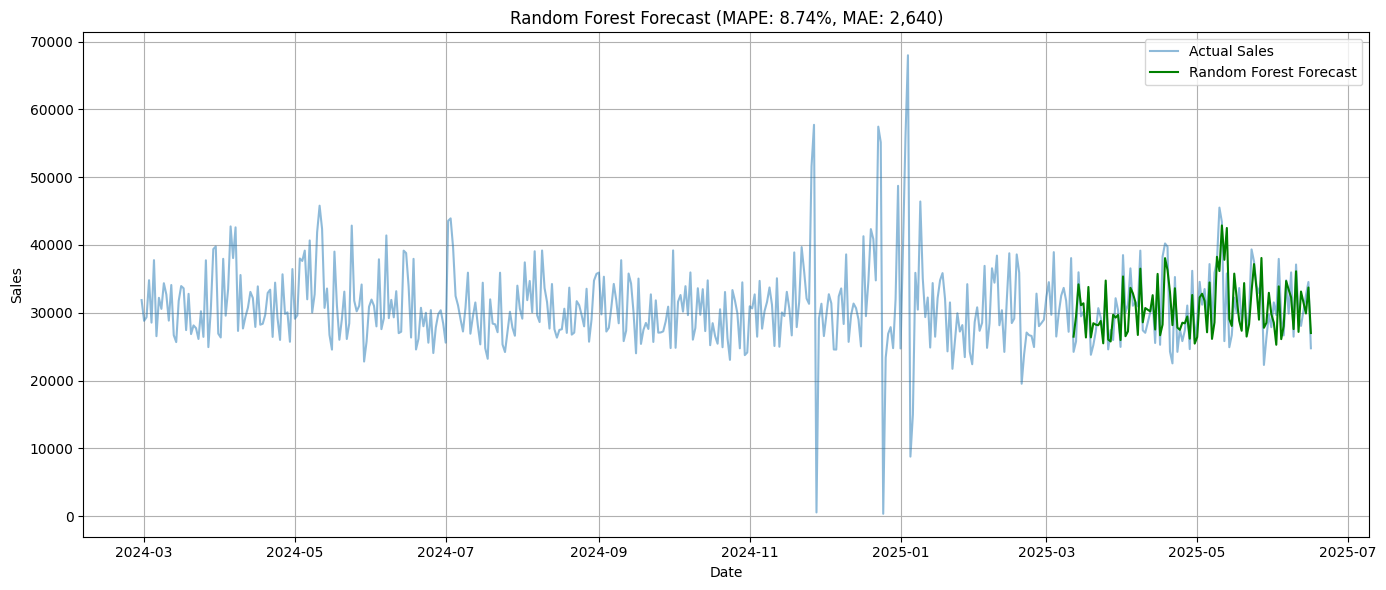

In [196]:

# Plot results
plt.figure(figsize=(14, 6))
plt.plot(ml_ds.index, ml_ds['sales'], label='Actual Sales', alpha=0.5)
plt.plot(ml_ds.index, ml_ds['forecast_rf'], label='Random Forest Forecast', color='green')
plt.title(f"Random Forest Forecast (MAPE: {mape_rf:.2%}, MAE: {mae_rf:,.0f})")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

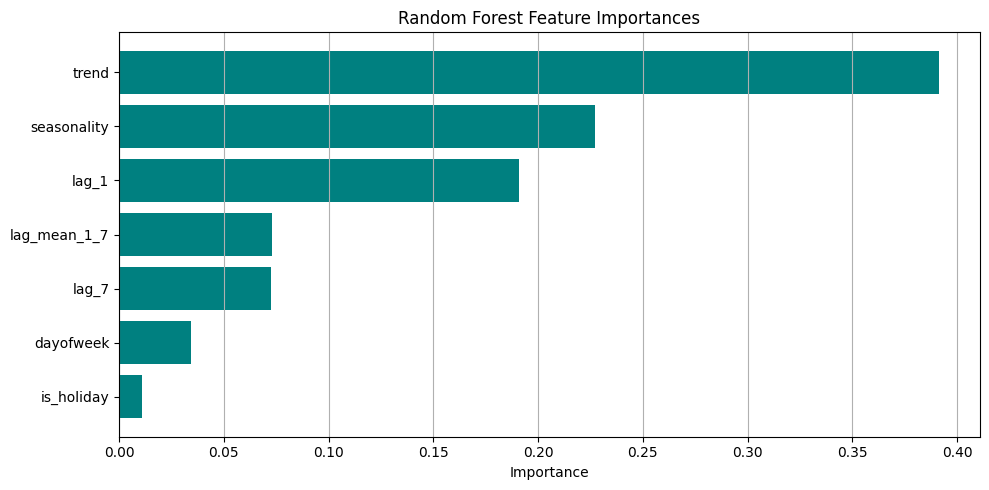

In [197]:
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 5))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='teal')
plt.xlabel('Importance')
plt.title('Random Forest Feature Importances')
plt.gca().invert_yaxis()
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()